# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Uriya 9752
# student 2: Shoval 2439

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics
import sklearn
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
%matplotlib inline

In [5]:
# Loading the training and test dataset files
df_train = pd.read_csv("titanic_train.csv")
df_test = pd.read_csv("titanic_test.csv")

In [6]:
# Displaying the first 5 rows of the loaded files
display(df_train.head())
display(df_test.head())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


In [7]:
#statistics and visualizations of the data 
df_train.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.294944,0.640449,29.531213,0.528090,0.384831,32.379429,0.372191,0.394663
std,0.841990,0.480206,13.188028,1.055052,0.803085,49.836074,0.649970,0.489122
min,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.750000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000,0.000000
50%,3.000000,1.000000,29.699118,0.000000,0.000000,14.500000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,1.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,1.000000


In [8]:
df_train.corr()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
Pclass,1.000000,0.126986,-0.319927,0.093572,0.048225,-0.543722,0.040708,-0.324024
Sex,0.126986,1.000000,0.089108,-0.079976,-0.242467,-0.183650,-0.124908,-0.550699
Age,-0.319927,0.089108,1.000000,-0.270404,-0.202725,0.071787,0.031524,-0.072729
SibSp,0.093572,-0.079976,-0.270404,1.000000,0.415491,0.136861,-0.049109,-0.031052
Parch,0.048225,-0.242467,-0.202725,0.415491,1.000000,0.151631,-0.072698,0.074699
Fare,-0.543722,-0.183650,0.071787,0.136861,0.151631,1.000000,0.078197,0.264345
Embarked,0.040708,-0.124908,0.031524,-0.049109,-0.072698,0.078197,1.000000,0.099162
Survived,-0.324024,-0.550699,-0.072729,-0.031052,0.074699,0.264345,0.099162,1.000000


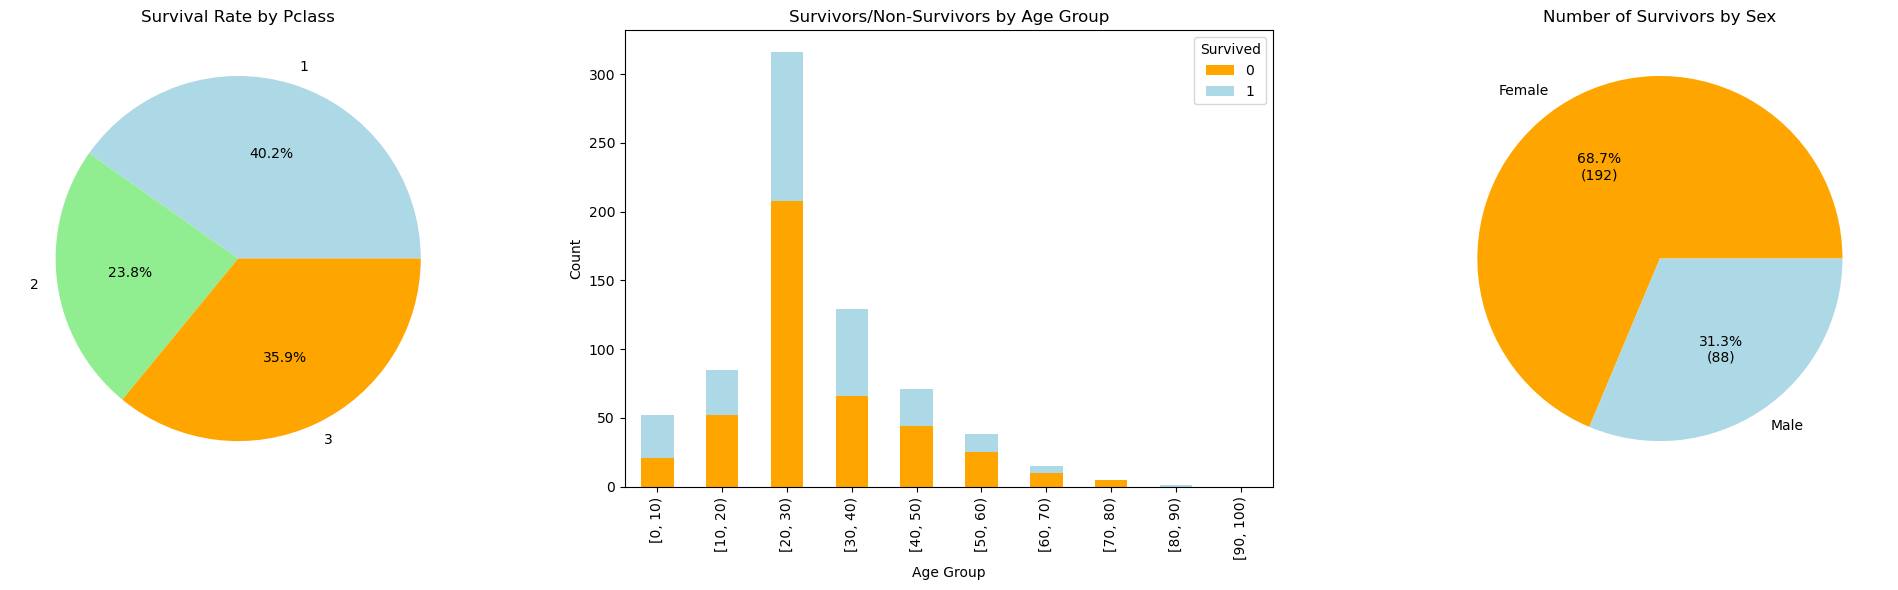

In [9]:
age_bins = range(0, 101, 10)
df_train['AgeGroup'] = pd.cut(df_train['Age'], bins=age_bins, right=False, include_lowest=True)

age_survival_count = df_train.groupby(['AgeGroup', 'Survived'], observed=False).size().unstack()

pclass_survival = df_train[df_train['Survived'] == 1].groupby('Pclass').size()
sex_survivor_count = df_train[df_train['Survived'] == 1]['Sex'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(21, 6))

pclass_survival.plot(kind='pie', autopct='%1.1f%%', ax=axs[0], colors=['lightblue', 'lightgreen', 'orange'])
axs[0].set_title('Survival Rate by Pclass')
axs[0].set_ylabel('')

age_survival_count.plot(kind='bar', stacked=True, ax=axs[1], color=['orange', 'lightblue'])
axs[1].set_title('Survivors/Non-Survivors by Age Group')
axs[1].set_xlabel('Age Group')
axs[1].set_ylabel('Count')

# Pie chart for survival by gender
axs[2].pie(sex_survivor_count, labels=['Female', 'Male'], autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sex_survivor_count)/100)})', colors=['orange', 'lightblue'])
axs[2].set_title('Number of Survivors by Sex')

plt.tight_layout()
plt.show()

df_train = df_train.drop(columns=['AgeGroup'])

## Part 3 - Experiments
You could add as many code cells as needed

In [17]:
def train_std_Scaling(X_train):
    scaling_info = pd.DataFrame({'mean': X_train.mean(), 'std': X_train.std()})
    X_train_scaled = (X_train - scaling_info['mean']) / scaling_info['std']
    return scaling_info, X_train_scaled

In [19]:
def test_std_Scaling(trained_scaling_info, X_test):
    X_test_scaled = (X_test - trained_scaling_info['mean']) / trained_scaling_info['std']
    return X_test_scaled

In [21]:
def train_minmax_Scaling(X_train):
    scaling_info = pd.DataFrame({'min': X_train.min(), 'max': X_train.max()})
    X_train_scaled = 2 * (X_train - scaling_info['min']) / (scaling_info['max'] - scaling_info['min']) - 1
    return scaling_info, X_train_scaled

In [23]:
def test_minmax_Scaling(trained_scaling_info, X_test):
    X_test_scaled = 2 * (X_test - trained_scaling_info['min']) / (trained_scaling_info['max'] - trained_scaling_info['min']) - 1
    return X_test_scaled

In [25]:
y_train = df_train.pop("Survived")
y_test = df_test.pop("Survived")

scaling_std_info, df_train_std_scaled = train_std_Scaling(df_train)
df_test_std_scaled = test_std_Scaling(scaling_std_info, df_test)

scaling_minmax_info, df_train_minmax_scaled = train_minmax_Scaling(df_train)
df_test_minmax_scaled = test_minmax_Scaling(scaling_minmax_info, df_test)

columns = ["Model", "Hyper Parameter", "Precision", "Recall", "F1", "Scaling Method"]
results = pd.DataFrame(columns=columns)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

knn_params = {'n_neighbors': [3, 5, 7, 9], 'metric': ['euclidean', 'chebyshev']}
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

def evaluate_model(model, X_test, y_test, scaling_method, hyper_param):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

for train_index, test_index in kf.split(df_train):
    X_split_std_train, X_split_std_test = df_train_std_scaled.iloc[train_index], df_train_std_scaled.iloc[test_index]
    y_split_train, y_split_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_split_minmax_train, X_split_minmax_test = df_train_minmax_scaled.iloc[train_index], df_train_minmax_scaled.iloc[test_index]
    
    for k in knn_params['n_neighbors']:
        for met in knn_params['metric']:
            knn_model_std = KNeighborsClassifier(n_neighbors=k, metric=met)
            knn_model_std.fit(X_split_std_train, y_split_train)
            precision, recall, f1 = evaluate_model(knn_model_std, X_split_std_test, y_split_test, "Std", f'k={k}, metric={met}')
            results.loc[len(results)] = ['KNN', f'k={k}, metric={met}', precision, recall, f1, 'Std']
            
            knn_model_minmax = KNeighborsClassifier(n_neighbors=k, metric=met)
            knn_model_minmax.fit(X_split_minmax_train, y_split_train)
            precision, recall, f1 = evaluate_model(knn_model_minmax, X_split_minmax_test, y_split_test, "MinMax", f'k={k}, metric={met}')
            results.loc[len(results)] = ['KNN', f'k={k}, metric={met}', precision, recall, f1, 'MinMax']
    
    for C in svm_params['C']:
        for kernel in svm_params['kernel']:
            svm_model_std = SVC(C=C, kernel=kernel)
            svm_model_std.fit(X_split_std_train, y_split_train)
            precision, recall, f1 = evaluate_model(svm_model_std, X_split_std_test, y_split_test, "Std", f'C={C}, kernel={kernel}')
            results.loc[len(results)] = ['SVM', f'C={C}, kernel={kernel}', precision, recall, f1, 'Std']
            
            svm_model_minmax = SVC(C=C, kernel=kernel)
            svm_model_minmax.fit(X_split_minmax_train, y_split_train)
            precision, recall, f1 = evaluate_model(svm_model_minmax, X_split_minmax_test, y_split_test, "MinMax", f'C={C}, kernel={kernel}')
            results.loc[len(results)] = ['SVM', f'C={C}, kernel={kernel}', precision, recall, f1, 'MinMax']

def calculate_priority(row):
    if row['Model'] == 'SVM':
        C_value = float(row['Hyper Parameter'].split('C=')[1].split(',')[0])
        return C_value
    elif row['Model'] == 'KNN':
        k_value = int(row['Hyper Parameter'].split('k=')[1].split(',')[0])
        return k_value
    return 0  

results['Priority'] = results.apply(calculate_priority, axis=1)

top_10_results = results.sort_values(by=['F1', 'Priority'], ascending=[False, True]).head(10)
top_10_results = top_10_results.drop(columns=['Priority'])

print("Top 10 results:")
print(top_10_results)

best_result = top_10_results.iloc[0]
print("\nBest result based on F1 score and priority:")
print(best_result)


Top 10 results:
    Model        Hyper Parameter  Precision    Recall        F1 Scaling Method
106   SVM        C=1, kernel=rbf   0.800000  0.765957  0.782609            Std
111   SVM       C=10, kernel=rbf   0.800000  0.765957  0.782609         MinMax
98    KNN  k=9, metric=chebyshev   0.745098  0.808511  0.775510            Std
135   SVM        C=1, kernel=rbf   0.886364  0.684211  0.772277         MinMax
42    KNN  k=9, metric=chebyshev   0.754098  0.779661  0.766667            Std
131   SVM      C=0.1, kernel=rbf   0.820000  0.719298  0.766355         MinMax
78    SVM        C=1, kernel=rbf   0.812500  0.722222  0.764706            Std
126   KNN  k=9, metric=chebyshev   0.833333  0.701754  0.761905            Std
134   SVM        C=1, kernel=rbf   0.883721  0.666667  0.760000            Std
128   SVM   C=0.1, kernel=linear   0.803922  0.719298  0.759259            Std

Best result based on F1 score and priority:
Model                          SVM
Hyper Parameter    C=1, kernel=rbf


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [28]:
def train_best_model(best_result, df_train, y_train):
    if best_result['Scaling Method'] == 'Std':
        scaling_info, df_train_scaled = train_std_Scaling(df_train)
    else:
        scaling_info, df_train_scaled = train_minmax_Scaling(df_train)

    if best_result['Model'] == 'KNN':
        k = int(best_result['Hyper Parameter'].split(', ')[0].split('=')[1])
        metric = best_result['Hyper Parameter'].split(', ')[1].split('=')[1]
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)

    elif best_result['Model'] == 'SVM':
        C = float(best_result['Hyper Parameter'].split(', ')[0].split('=')[1])
        kernel = best_result['Hyper Parameter'].split(', ')[1].split('=')[1]
        model = SVC(C=C, kernel=kernel)

    model.fit(df_train_scaled, y_train)

    return model, scaling_info

best_model, scaling_info = train_best_model(best_result, df_train, y_train)


## Part 5 - Apply on test and show model performance estimation

In [31]:
def predict_and_evaluate(model, df_test, y_test, scaling_info, scaling_method):
    if scaling_method == 'Std':
        df_test_scaled = test_std_Scaling(scaling_info, df_test)
    else:
        df_test_scaled = test_minmax_Scaling(scaling_info, df_test)

    y_pred = model.predict(df_test_scaled)

    print("First 5 predictions on the Test Set:")
    for i in range(5):
        print(f"Sample {i+1}: Predicted: {y_pred[i]}, Actual: {y_test.iloc[i]}")
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\nModel performance on the Test Set:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

predict_and_evaluate(best_model, df_test, y_test, scaling_info, best_result['Scaling Method'])


First 5 predictions on the Test Set:
Sample 1: Predicted: 0, Actual: 0
Sample 2: Predicted: 0, Actual: 0
Sample 3: Predicted: 0, Actual: 0
Sample 4: Predicted: 1, Actual: 0
Sample 5: Predicted: 0, Actual: 1

Model performance on the Test Set:
Precision: 0.7857
Recall: 0.7213
F1 Score: 0.7521
